In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
dataset = pd.read_csv('data/dataset_transformed.csv')
dataset.head()

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,...,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Educación profesional completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Educación profesional incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta,FAMI_EDUCACIONMADRE_No Aplica,FAMI_EDUCACIONMADRE_No sabe,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,20183.0,1.664298,1.533911,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,20195.0,1.791667,1.460920,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,20195.0,1.640811,1.426440,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,20195.0,1.447136,1.406953,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
4,20183.0,0.396624,1.460920,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
import torch.utils
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

x = dataset.drop('RENDIMIENTO_GLOBAL', axis=1).values
y = dataset['RENDIMIENTO_GLOBAL'].values

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

train_size = int(0.8 * len(x))
test_size = len(x) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(TensorDataset(x, y), [train_size, test_size], generator=torch.Generator().manual_seed(23))

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



class NNModel(nn.Module):
    def __init__(self,input_layer, output_layer, hidden_layers = 20, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sequiential_layer = nn.Sequential(
            nn.Linear(input_layer,hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers,hidden_layers//2),
            nn.ReLU(),
            nn.Linear(hidden_layers//2,output_layer),
            nn.Dropout(0.5)
        )
        self.sequiential_layer2 = nn.Sequential(
            nn.Linear(hidden_layers,hidden_layers//2),
            nn.ReLU(),
            nn.Linear(hidden_layers//2,hidden_layers//2),
            nn.ReLU(),
            nn.Linear(hidden_layers//2,hidden_layers//4),
            nn.Dropout(0.5)
        )
        self.sequiential_layer3 = nn.Sequential(
            nn.Linear(hidden_layers//4,hidden_layers//8),
            nn.ReLU(),
            nn.Linear(hidden_layers//8,hidden_layers//8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers//8,output_layer)
        )
    def forward(self, x:torch.Tensor):
        x = self.sequiential_layer(x)
        #x = self.sequiential_layer2(x)
        #x = self.sequiential_layer3(x)
        return x


input_size = 49


torch.manual_seed(23)
num_classes = len(dataset['RENDIMIENTO_GLOBAL'].unique())

model = NNModel(49, num_classes, 100).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
loss_fn = nn.CrossEntropyLoss()


num_epochs = 100


patience = 5
best_loss = float('inf')
counter = 0

for epoch in tqdm(range(num_epochs)):

    train_loss, train_acc = 0, 0

    model.train()
    for batch, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device).long()
        y_logit = model(x)
        loss = loss_fn(y_logit, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        train_acc += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    with torch.inference_mode():
        for batch, (x, y) in enumerate(test_loader):

            test_loss, test_acc = 0, 0
            x = x.to(device)
            y = y.to(device).long()
            y_logit = model(x)
            loss = loss_fn(y_logit, y)
            test_loss += loss.item()
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            test_acc += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
    
    #scheduler.step(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    print(f'Train| Loss: {train_loss}, acc: {train_acc}')
    print(f'Test| Loss: {test_loss}, acc: {test_acc}')

    print("-"*50)

    


  1%|          | 1/100 [00:12<19:54, 12.07s/it]

Train| Loss: 2.8907705887360606, acc: 0.25110421478060047
Test| Loss: 0.002568064140657657, acc: 0.0
--------------------------------------------------


  2%|▏         | 2/100 [00:23<19:02, 11.66s/it]

Train| Loss: 1.3866546190363156, acc: 0.2505972142032333
Test| Loss: 0.0025506439684061986, acc: 0.00046125461254612545
--------------------------------------------------


  3%|▎         | 3/100 [00:36<19:30, 12.07s/it]

Train| Loss: 1.3867040440336937, acc: 0.250196665704388
Test| Loss: 0.0025886501773257097, acc: 0.0
--------------------------------------------------


  4%|▍         | 4/100 [00:48<19:32, 12.21s/it]

Train| Loss: 1.38663926240203, acc: 0.25051963048498843
Test| Loss: 0.0025841303417163584, acc: 0.00046125461254612545
--------------------------------------------------


  5%|▌         | 5/100 [01:00<19:15, 12.16s/it]

Train| Loss: 1.3866433897414878, acc: 0.2506008227482679
Test| Loss: 0.0025566268671042805, acc: 0.0009225092250922509
--------------------------------------------------


  6%|▌         | 6/100 [01:11<18:28, 11.79s/it]

Train| Loss: 1.3866711177671753, acc: 0.25117458140877597
Test| Loss: 0.002559631952940318, acc: 0.00046125461254612545
--------------------------------------------------


  6%|▌         | 6/100 [01:23<21:51, 13.95s/it]

Early stopping at epoch 6


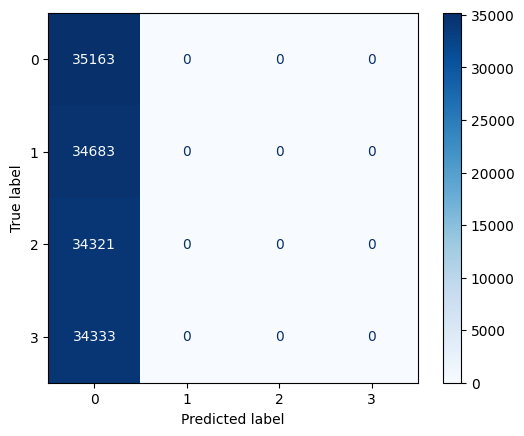

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        predicted = torch.softmax(outputs, dim=1).argmax(dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Paso 2: Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Paso 3: Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()